<a href="https://colab.research.google.com/github/PerceptronV/Miscellaneous/blob/master/Venue_Embedding_and_User_Rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embedding-Based Venue Search & User Recommendation
_A demo for luna by Yiding Song (Vincent)._

This is not an app. But I do have a neat algorithm.

My strength is not in IOS app dev, but I did make a neat ML-powered backend system. _In fact, I built a graph neural network from scratch that can find missing links in social networks for networking recommendations based on user preference._

In [1]:
# @markdown Install Dependencies & Import libraries

!pip install -q -U sentence-transformers

import os
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q -U torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q -U torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q -U git+https://github.com/pyg-team/pytorch_geometric.git

import numpy as np
from scipy import stats
from torch_geometric.data import Data as GData
import torch_geometric.nn as gnn


torch.manual_seed(91387)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


2.4.1+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/libpyg.so: undefined symbol: _ZN3c1010Dispatcher17runRecordFunctionERN2at14RecordFunctionESt17reference_wrapperIKNS_14FunctionSchemaEENS_11DispatchKeyE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_clu

## Part A - The Venue Search Problem

### Simulation Scenario


In [2]:
# @markdown Restaurant information
restaurant_names = ["Nine Tastes", "Hokkaido Ramen Santouka", "Tasty Burger", "Tatte Bakery", "El Jefe", "Joe's Pizza"]
restaurants = {
    "Nine Tastes": "Nine Tastes, 3.5/5, 80 reviews, #182 of 421 Restaurants in Cambridge, $$ - $$$, Thai, Vegetarian friendly, Vegan options",
    "Hokkaido Ramen Santouka": "Hokkaido Ramen Santouka, 4.5/5, 203 reviews, #8 of 421 Restaurants in Cambridge, $$ - $$$, Japanese, Asian, Soups",
    "Tasty Burger": "Tasty Burger, 3.5/5, 116 reviews, #20 of 54 Quick Bites in Cambridge, $, Quick Bites, American, Fast Food",
    "Tatte Bakery": "Tatte Bakery & Cafe | Third St, 4.5/5, 240 reviews, #2 of 38 Coffee & Tea in Cambridge, $$ - $$$, Bakeries, American, Cafe",
    "El Jefe": "El Jefe's Taqueria, 3.5/5, 14 reviews, #50 of 54 Quick Bites in Cambridge, $, Quick Bites, Mexican",
    "Joe's Pizza": "Joe's Pizza (Harvard Square), 3/5, 1 review, #51 of 54 Quick Bites in Cambridge, Quick Bites, Italian, Pizza"
}

In [3]:
user_names = ['Nico', 'Vincent', 'Jed', 'Elon', 'Mark']
users = {k: {} for k in user_names}

### User Preferences

In [4]:
# @markdown Nico
Text = "Can we do Thai food?" # @param {"type":"string","placeholder":"What do you wanna get?"}
Certainty = 0.8 # @param {"type":"slider","min":0,"max":1,"step":0.05}
users['Nico']['text'] = Text
users['Nico']['certainty'] = Certainty

In [5]:
# @markdown Vincent
Text = "I want some curry tonight." # @param {"type":"string","placeholder":"What do you wanna get?"}
Certainty = 0.65 # @param {"type":"slider","min":0,"max":1,"step":0.05}
users['Vincent']['text'] = Text
users['Vincent']['certainty'] = Certainty

In [6]:
# @markdown Jed
Text = "Down for a nice grill place!" # @param {"type":"string","placeholder":"What do you wanna get?"}
Certainty = 0.45 # @param {"type":"slider","min":0,"max":1,"step":0.05}
users['Jed']['text'] = Text
users['Jed']['certainty'] = Certainty

In [7]:
# @markdown Elon
Text = "I want expensive sushi or coffee." # @param {"type":"string","placeholder":"What do you wanna get?"}
Certainty = 0.6 # @param {"type":"slider","min":0,"max":1,"step":0.05}
users['Elon']['text'] = Text
users['Elon']['certainty'] = Certainty

In [8]:
# @markdown Mark
Text = "Something fast haha!" # @param {"type":"string","placeholder":"What do you wanna get?"}
Certainty = 0.2 # @param {"type":"slider","min":0,"max":1,"step":0.05}
users['Mark']['text'] = Text
users['Mark']['certainty'] = Certainty

### Initial Heatmap

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


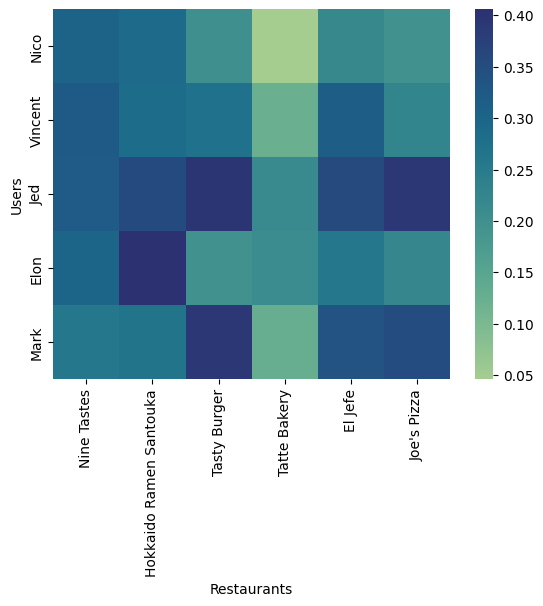

In [9]:
user_texts = ['Food: ' + users[n]['text'] for n in user_names]
user_certs = torch.tensor([users[n]['certainty'] for n in user_names])
restaurant_descriptions = ['Restaurant: ' + restaurants[n] for n in restaurant_names]

model = SentenceTransformer("all-MiniLM-L6-v2")

request_embeddings = model.encode(user_texts)
restaurant_embeddings = model.encode(restaurant_descriptions)
similarities = model.similarity(request_embeddings, restaurant_embeddings)

ax = sns.heatmap(similarities,
                 xticklabels=restaurant_names,
                 yticklabels=user_names,
                 cmap="crest")
ax.set_xlabel("Restaurants")
ax.set_ylabel("Users")
plt.show()

### Revalued Heatmap

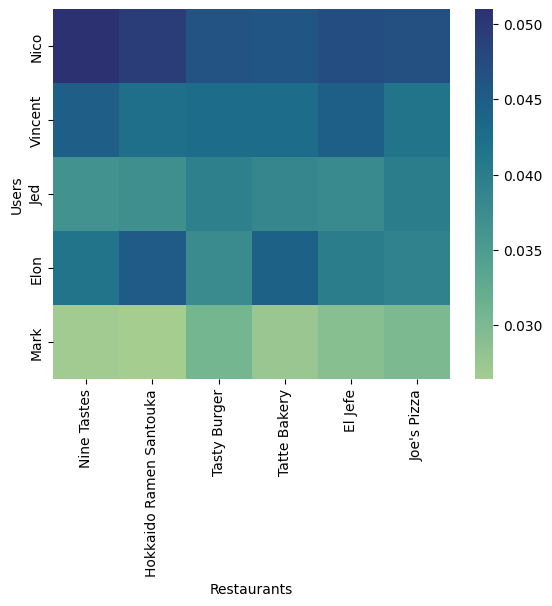

In [10]:
revalued = F.softmax(user_certs, dim=0).unsqueeze(dim=1) * F.softmax(similarities, dim=0)

ax = sns.heatmap(revalued,
                 xticklabels=restaurant_names,
                 yticklabels=user_names,
                 cmap="crest")
ax.set_xlabel("Restaurants")
ax.set_ylabel("Users")
plt.show()

### Final Scores

Restaurant with highest score is: Nine Tastes


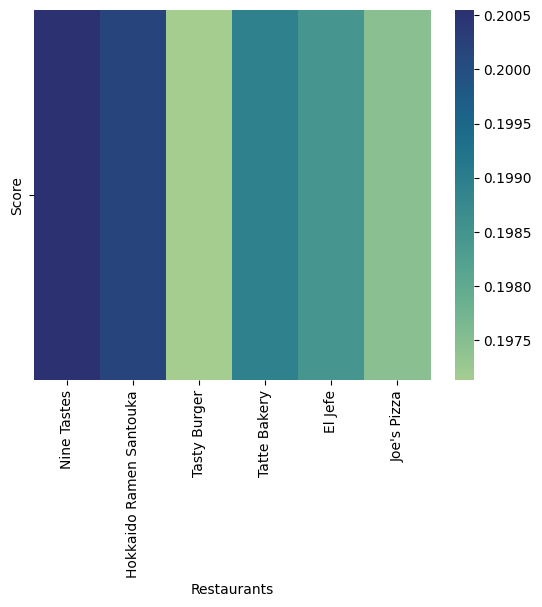

Nine Tastes: 0.2005445659160614
Hokkaido Ramen Santouka: 0.20016802847385406
Tasty Burger: 0.1971326321363449
Tatte Bakery: 0.19892911612987518
El Jefe: 0.19845715165138245
Joe's Pizza: 0.19747021794319153


In [11]:
scores = torch.sum(revalued, dim=0)
print(f'Restaurant with highest score is: {restaurant_names[torch.argmax(scores)]}')

ax = sns.heatmap(scores.unsqueeze(dim=0),
                 yticklabels=["Score"],
                 xticklabels=restaurant_names,
                 cmap="crest")
ax.set_xlabel("Restaurants")
plt.show()

for e, n in enumerate(restaurant_names):
    print(f'{n}: {scores[e]}')

## Part B - The User Recommendation Problem

In [12]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


### Problem Setup

In [13]:
num_users = 1000 # @param {"type":"integer","placeholder":"1000"}
dim_embed = 512 # @param {"type":"integer","placeholder":"512"}
threshold = 0.55 # @param {"type":"slider","min":0,"max":1,"step":0.01}
keep = 0.8 # @param {"type":"slider","min":0,"max":1,"step":0.01}

### Constructing a Simulated Dataset

In [14]:
def batch_similarity(a, b):
    norm_a = torch.norm(a, dim=1)
    norm_b = torch.norm(b, dim=1)
    sim = (a @ b.t()) / (2 * torch.outer(norm_a, norm_b)) + 0.5
    return sim

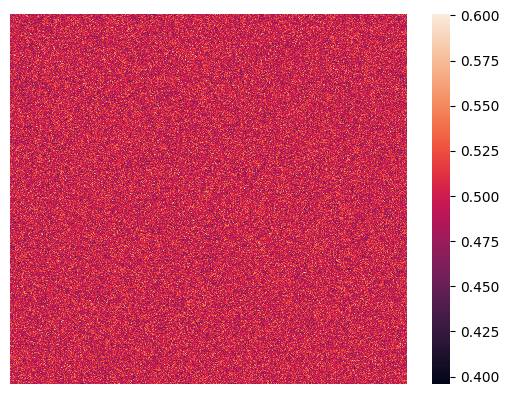

In [15]:
user_embeddings = torch.randn(num_users, dim_embed)
user_weights = torch.randn(num_users, dim_embed, dim_embed)
user_preferred = user_embeddings + (user_weights @ user_embeddings.unsqueeze(dim=2)).squeeze(dim=2)

scores = batch_similarity(user_preferred, user_embeddings)
_ = sns.heatmap(scores, xticklabels=[], yticklabels=[])

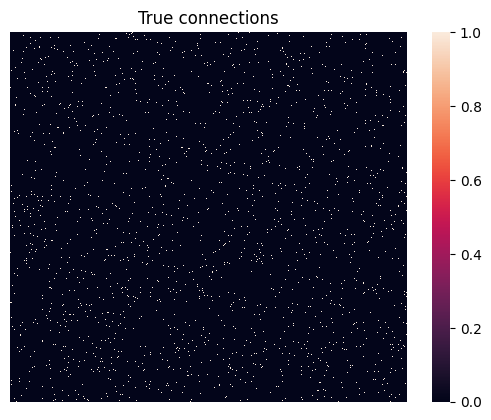

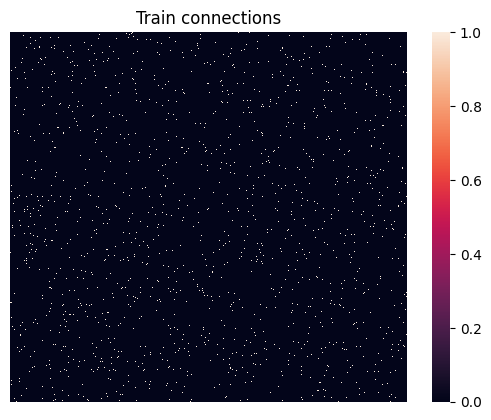

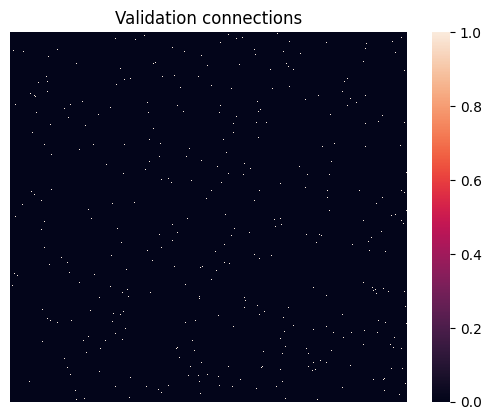

In [53]:
connections = torch.where(scores > threshold, 1, 0)

invnorm = stats.norm.ppf(keep)
noise = torch.where(torch.randn(num_users, num_users)<invnorm, 1, 0)
train_connections = connections * noise
val_connections = connections * (1 - train_connections)

_ = sns.heatmap(connections, xticklabels=[], yticklabels=[])
plt.title("True connections")
plt.show()

_ = sns.heatmap(train_connections, xticklabels=[], yticklabels=[])
plt.title("Train connections")
plt.show()

_ = sns.heatmap(val_connections, xticklabels=[], yticklabels=[])
plt.title("Validation connections")
plt.show()

In [54]:
print(f"# edges for true connections: {connections.sum().item()}")
print(f"# edges for train connections: {train_connections.sum().item()}")
print(f"# edges for validation connections: {val_connections.sum().item()}")

# edges for true connections: 11753
# edges for train connections: 9394
# edges for validation connections: 2359


In [55]:
edgelist = train_connections.nonzero().t().contiguous()
data = GData(x=user_embeddings,
             train_mask=train_connections.flatten().bool(),
             val_mask=val_connections.flatten().bool(),
             y=scores.flatten(),
             edge_index=edgelist).to(device)

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 1000
Number of edges: 9394
Has isolated nodes: False
Has self-loops: True
Is undirected: False


### Graph Convolutional Neural Network

In [79]:
class GCN(torch.nn.Module):
    def __init__(self, dim_embed, dim_hidden=4):
        super().__init__()
        self.conv1 = gnn.GCNConv(dim_embed, dim_hidden)
        self.conv2 = gnn.GCNConv(dim_hidden, dim_hidden)
        self.conv3 = gnn.GCNConv(dim_hidden, dim_embed)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)
        h = h.relu()
        scores = batch_similarity(h, user_embeddings.to(device))
        return scores, h

In [80]:
model = GCN(dim_embed).to(device)
print(model)

GCN(
  (conv1): GCNConv(512, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 512)
)


In [82]:
num_epochs = 5000
every = 100
loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.01)

def train(data):
    out, _ = model(data.x, data.edge_index)
    pred = out.flatten()
    loss = loss_fn(pred[data.train_mask], data.y[data.train_mask])

    loss.backward()
    optim.step()
    optim.zero_grad()
    return loss

for epoch in range(num_epochs):
    loss = train(data)
    if epoch % every == every - 1:
        out, _ = model(data.x, data.edge_index)
        pred = out.flatten()
        val_loss = loss_fn(pred[data.val_mask], data.y[data.val_mask])

        print(f'.\nEpoch {epoch+1}, Train: {loss:.5f}, Val: {val_loss:.5f}')
    else:
        print('.', end='')

....................................................................................................
Epoch 100, Train: 0.00217, Val: 0.00326
....................................................................................................
Epoch 200, Train: 0.00214, Val: 0.00328
....................................................................................................
Epoch 300, Train: 0.00213, Val: 0.00328
....................................................................................................
Epoch 400, Train: 0.00211, Val: 0.00331
....................................................................................................
Epoch 500, Train: 0.00211, Val: 0.00329
....................................................................................................
Epoch 600, Train: 0.00212, Val: 0.00330
....................................................................................................
Epoch 700, Train: 0.00209, Val: 0.00331
.............

In [83]:
out, _ = model(data.x, data.edge_index)
pred = out.cpu().detach()
print(f'Pred min: {pred.min():.4f}, max: {pred.max():.4f}.')
print(f'True min: {scores.min():.4f}, max: {scores.max():.4f}.')

Pred min: 0.3975, max: 0.5908.
True min: 0.3959, max: 0.6006.


In [84]:
def eval(name, pred):
    test_scores = scores.flatten()[(1-train_connections).flatten().bool()]
    test_pred = pred.flatten()[(1-train_connections).flatten().bool()]

    r = stats.pearsonr(test_scores, test_pred)
    print(f'{name} pearson r: {r[0]:.4f}')

    discrete_pred = torch.where(pred > threshold, 1, 0)
    diff = (discrete_pred - connections) * (1 - train_connections)
    print(f'{name} dp-c: {torch.unique(diff, return_counts=True)}')

    recovered = torch.sum(discrete_pred * connections * (1 - train_connections))
    lost = torch.sum(connections) - torch.sum(train_connections)
    print(f"{name} lost connections recovered: {recovered*100/lost:.4f}%")

In [85]:
eval('Model', pred)
print()
eval('Baseline', batch_similarity(user_embeddings, user_embeddings))

Model pearson r: 0.0282
Model dp-c: (tensor([-1,  0,  1]), tensor([  2311, 981992,  15697]))
Model lost connections recovered: 2.0348%

Baseline pearson r: 0.0503
Baseline dp-c: (tensor([-1,  0,  1]), tensor([  2310, 985561,  12129]))
Baseline lost connections recovered: 2.0772%
